In [1]:
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import numpy as np
import os
from pathlib import Path
import json
import collections

In [2]:
# Specify the parent folder paths in a list
folders = [
    '/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/models/sentiment_unified_labels/P_1_PQA_5_promptsource_False/dataset_1/15-07-23_16:49/checkpoint-50000/inference/07-18-15:21',
    '/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/models/sentiment_unified_labels/P_1_PQA_5_promptsource_False/dataset_0.5/16-07-23_15:27/checkpoint-50000/inference/07-18-14:43',
    '/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/models/sentiment_unified_labels/P_1_PQA_5_promptsource_False/dataset_0.1/16-07-23_15:18/checkpoint-50000/',
    '/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/models/sentiment_c4/P_1_PQA_5_promptsource_True/dataset_0/10-07-23_15:26/save_for_later/checkpoint-52000/inference/07-19-14:31',
    '/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/models/sentiment_only/P_1_PQA_5_promptsource_True/dataset_1/19-07-23_14:55/checkpoint-50000/inference/07-20-18:42',
    '/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/models/sentiment_c4_small/P_1_PQA_5_promptsource_True/dataset_1/19-07-23_12:47/checkpoint-50000/inference/07-20-18:25',
    '/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/models/sentiment_unified_labels/P_1_PQA_5_promptsource_False/dataset_0.1/16-07-23_15:18/checkpoint-124000/inference/07-21-15:14'
]

fig_save_path = "./models/sentiment_c4/figures"
keywords = ["sentiment", "dataset", "checkpoint", "promptsource"]

print("Number of folders: ", len(folders))

Number of folders:  7


In [3]:
def filter_path(path, keywords):
    parts = path.split(os.sep)
    filtered_parts = []
    for part in parts:
        if any(keyword in part for keyword in keywords):
            filtered_parts.append(part)
        if len(filtered_parts) == len(keywords):
            break
    return os.sep.join(filtered_parts)

# Define a function to find and extract the score from a score.txt file
def get_scores(folders, filename):
    scores = {}
    for folder_path in folders:
        # Search for score.txt files in the folder and its subdirectories
        score_files = glob.glob(f'{folder_path}/**/{filename}', recursive=True)

        # If no score file is found, raise an exception
        if not score_files:
            raise FileNotFoundError(f'No score.txt file found in {folder_path} or its subdirectories.')

        # If more than one score file is found, raise an exception
        if len(score_files) > 1:
            raise ValueError(f'More than one score.txt file found in {folder_path} or its subdirectories.')

        # Read the score from the score file
        with open(score_files[0], 'r') as file:
            score = float(file.read().strip())  # Change to int if the score is an integer
        score_key = filter_path(folder_path, keywords=["dataset", "checkpoint"])
        scores[score_key] = score
    return scores

# Define a function to find and extract the score from a score.txt file
def get_scores_json(folders, filename, key=None):
    scores = {}
    for folder_path in folders:
        # Search for score.txt files in the folder and its subdirectories
        score_files = glob.glob(f'{folder_path}/**/{filename}', recursive=True)

        # If no score file is found, raise an exception
        if not score_files:
            raise FileNotFoundError(f'No score file found in {folder_path} or its subdirectories.')

        # If more than one score file is found, raise an exception
        if len(score_files) > 1:
            raise ValueError(f'More than one score file found in {folder_path} or its subdirectories.')

        # Read the score from the score file
        with open(score_files[0], 'r') as file:
            score = json.load(file)
        if key is not None:
            score = score[key]
        score_key = filter_path(folder_path, keywords)
        scores[score_key] = score
    return scores

def filter_path(path, keywords):
    parts = path.split(os.sep)
    filtered_parts = []
    for part in parts:
        if any(keyword in part for keyword in keywords):
            filtered_parts.append(part)
        if len(filtered_parts) == len(keywords):
            break
    return os.sep.join(filtered_parts)

def plot_scores(scores_dict, title, reverse=False):
    # Get unique labels
    labels = {path: filter_path(path, keywords) for path in scores_dict.keys()}
    unique_labels = list(set(labels.values()))

    # Create a color map
    color_map = plt.colormaps.get_cmap('tab10')  # Choose the color map you like
    colors = color_map(np.linspace(0, 1, len(unique_labels)))

    # Create a dictionary mapping labels to colors
    label_color_dict = {label: color for label, color in zip(unique_labels, colors)}

    # Sort labels and scores in decreasing order by scores
    items = []
    for path, label in labels.items():
        score = scores_dict[path]
        if isinstance(score, dict):
            score = score.get('mean', 0)  # use the 'mean' value if it exists, otherwise use 0
        items.append((label, score))
    items = sorted(items, key=lambda x: x[1], reverse=reverse)
    labels, scores = zip(*items)

    # Plot the bars with colors according to their labels
    for i, score in enumerate(scores):
        plt.bar(i, score, color=label_color_dict[labels[i]])

    plt.ylabel('Average Score')
    plt.title(title)

    # Create custom legend
    patches = [mpatches.Patch(color=color, label=label) for label, color in label_color_dict.items()]
    plt.legend(handles=patches)

    plt.xticks([])  # Remove x-axis labels
    # ylims = min(scores) - (min(scores) * 0.025), max(scores) + (max(scores) * 0.025)
    plt.ylim(min(scores) - 0.2, max(scores) + 0.2)  # Add some margin at the top and bottom
    plt.tight_layout()  # Adjust layout so labels aren't cut off
    plt.show()

In [4]:
# filename_txt = 'rank.txt'
# scores_dict = get_scores(folders, filename_txt)
# title = 'Rank Classification (Lower is Better)'
# plot_scores(scores_dict, title)

In [5]:
# filename_logprob = 'log_probs.txt'
# scores_dict = get_scores(folders, filename_logprob)
# title = 'Log Probability (Less negative is Better)'
# plot_scores(scores_dict, title)

In [6]:
file_paths = folders

rank_dict = get_scores_json(file_paths, 'rank.json')
logprob_dict = get_scores_json(file_paths, 'log_probs.json')


print(len(rank_dict))


7


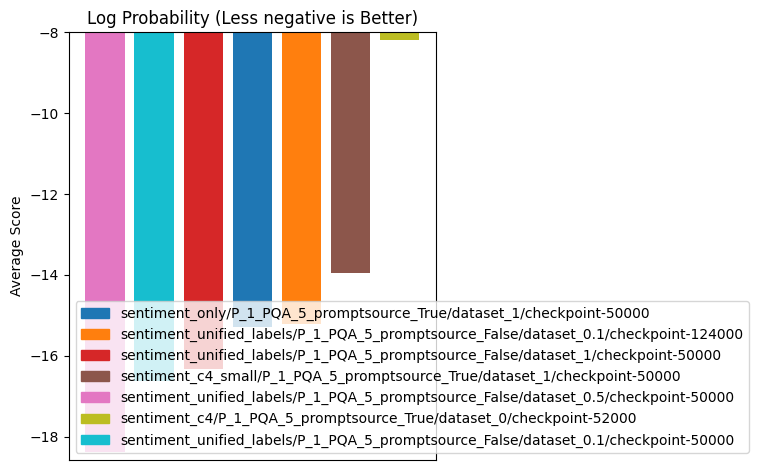

In [7]:
title = 'Log Probability (Less negative is Better)'
plot_scores(logprob_dict, title)

In [8]:
for key, value in rank_dict.items():
    print(key)
    for key, value in value.items():
        print(key, value)

sentiment_unified_labels/P_1_PQA_5_promptsource_False/dataset_1/checkpoint-50000
mean 1.196319018404908
std 0.42217029640650067
samples [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1,

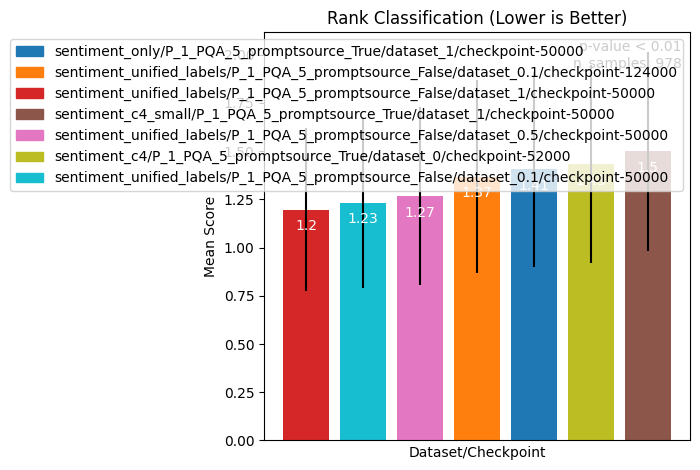

In [9]:
import pandas as pd
from itertools import combinations
from scipy.stats import ttest_ind_from_stats

def get_significance(mean_diff, std1, std2, n1, n2):
    # Calculating the means
    mean1 = 0  # assuming mean of first sample is 0
    mean2 = mean_diff  # mean of second sample is difference in mean
  
    # Perform t-test
    t_stat, p_value = ttest_ind_from_stats(mean1=mean1, std1=std1, nobs1=n1, 
                                           mean2=mean2, std2=std2, nobs2=n2)

    return p_value

def compare_all_pairs(rank_dict):
    # Get all unique pairs of keys
    keys = list(rank_dict.keys())
    pairs = list(combinations(keys, 2))

    # Initialize results list
    results = []

    # Compare each pair
    for key1, key2 in pairs:
        mean1 = rank_dict[key1]['mean']
        mean2 = rank_dict[key2]['mean']
        std1 = rank_dict[key1]['std']
        std2 = rank_dict[key2]['std']
        n1 = rank_dict[key1]['n']
        n2 = rank_dict[key2]['n']

        p_value = get_significance(mean2 - mean1, std1, std2, n1, n2)

        result = {
            'key1': key1,
            'key2': key2,
            'mean1': mean1,
            'mean2': mean2,
            'std1': std1,
            'std2': std2,
            'n1': n1,
            'n2': n2,
            'p_value': p_value
        }

        results.append(result)

    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)

    return results_df

def plot_rank_classification(rank_dict, fig_title, fig_save_path,
                             reverse=False, p_value=None, n_samples=None,
                             std_error=True):
    # Filter and create labels for keys
    labels = {key: filter_path(key, keywords=keywords) for key in rank_dict.keys()}
    unique_labels = list(set(labels.values()))

    # Create a color map
    color_map = plt.get_cmap('tab10')  # Choose the color map you like
    colors = color_map(np.linspace(0, 1, len(unique_labels)))

    # Create a dictionary mapping labels to colors
    label_color_dict = {label: color for label, color in zip(unique_labels, colors)}

    # Extract keys, means and stds from the dictionary, and sort by means
    items = []
    for key, label in labels.items():
        mean = rank_dict[key]['mean']
        std = rank_dict[key]['std'] if std_error else 0
        items.append((label, mean, std))
    items.sort(key=lambda x: x[1], reverse=reverse)  # Sort by mean

    labels, means, stds = zip(*items)  # Unzip sorted items

    # Create the bar plot with colors according to their labels
    bars = [plt.bar(i, mean, yerr=std, color=label_color_dict[label]) for i, (label, mean, std) in enumerate(zip(labels, means, stds))]

    # Add text inside the bars
    for i, bar in enumerate(bars):
        yval = bar[0].get_height()
        plt.text(bar[0].get_x() + bar[0].get_width() / 2, yval - 0.05, round(yval, 2), ha='center', va='top', color='white')

    # Customize the plot
    plt.ylabel('Mean Score')
    plt.xlabel('Dataset/Checkpoint')
    plt.title(fig_title)
    plt.xticks(range(len(labels)), labels, rotation=45)  # Rotate x-axis labels for better readability
    plt.xticks([])  # Remove x-axis labels

    # Create custom legend
    patches = [mpatches.Patch(color=color, label=label) for label, color in label_color_dict.items()]
    plt.legend(handles=patches)

    # If p_value and/or n_samples are provided, display them as text on the top right
    text = []
    if p_value is not None:
        if p_value < 0.01:
            p_value = 0.01
        text.append(f'p-value < {p_value}')  # Format p-value as scientific notation with 2 decimal places
    if n_samples is not None:
        text.append(f'n_samples: {n_samples}')
    if text:
        plt.text(0.98, 0.98, '\n'.join(text), transform=plt.gca().transAxes, ha='right', va='top')

    plt.tight_layout()  # Adjust layout so labels aren't cut off

    # Save the figure
    plt.savefig(os.path.join(fig_save_path, 'rank.png'))

    # Show the plot
    plt.show()

rank_title = 'Rank Classification (Lower is Better)'
comparison_df = compare_all_pairs(rank_dict)
p_value, n_samples = comparison_df['p_value'].min(), comparison_df['n1'].min()
plot_rank_classification(rank_dict, rank_title, fig_save_path, p_value=p_value, n_samples=n_samples)

In [10]:
pd.DataFrame(rank_dict).T

,mean,std,samples,n
sentiment_unified_labels/P_1_PQA_5_promptsource_False/dataset_1/checkpoint-50000,1.196319,0.42217,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, ...",978
sentiment_unified_labels/P_1_PQA_5_promptsource_False/dataset_0.5/checkpoint-50000,1.266871,0.460446,"[1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, ...",978
sentiment_unified_labels/P_1_PQA_5_promptsource_False/dataset_0.1/checkpoint-50000,1.232106,0.441127,"[1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, ...",978
sentiment_c4/P_1_PQA_5_promptsource_True/dataset_0/checkpoint-52000,1.432515,0.51167,"[1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, ...",978
sentiment_only/P_1_PQA_5_promptsource_True/dataset_1/checkpoint-50000,1.40593,0.505436,"[1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, ...",978
sentiment_c4_small/P_1_PQA_5_promptsource_True/dataset_1/checkpoint-50000,1.498978,0.5161,"[1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, ...",978
sentiment_unified_labels/P_1_PQA_5_promptsource_False/dataset_0.1/checkpoint-124000,1.368098,0.498961,"[1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, ...",978


In [11]:
# def plot_hexbin(rank_dict, fig_save_path, keys=None, gridsize=20, cmap='Blues', title='Rank Classification'):
#     if keys is None:
#         keys = list(rank_dict.keys())

#     # Generate all unique pairs of keys
#     key_pairs = list(combinations(keys, 2))

#     # Calculate the number of subplots needed
#     num_plots = len(key_pairs)
#     num_cols = round(num_plots**0.5)
#     num_rows = num_cols + (num_plots % num_cols > 0)

#     # Create a new figure
#     fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))

#     # Make sure axs is always a 2D array
#     if num_rows == 1:
#         axs = axs.reshape(1, -1)
#     if num_cols == 1:
#         axs = axs.reshape(-1, 1)

#     # Iterate over all unique pairs of keys and create a hexbin plot for each
#     for (key1, key2), ax in zip(key_pairs, axs.flat):
#         samples1 = rank_dict[key1]['samples']
#         samples2 = rank_dict[key2]['samples']

#         hexplot = ax.hexbin(samples1, samples2, gridsize=gridsize, cmap=cmap)
#         ax.set_xlabel(key1)
#         ax.set_ylabel(key2)
#         ax.set_title(title)
#         fig.colorbar(hexplot, ax=ax)

#     # Hide unused subplots
#     for ax in axs.flat[num_plots:]:
#         ax.axis('off')

#     plt.tight_layout()
#     plt.savefig(os.path.join(fig_save_path, 'rank_hexbin.png'))
#     plt.show()

# plot_hexbin(rank_dict, fig_save_path)

In [12]:
generated_samples = get_scores_json(file_paths, 'generated_samples.json')

In [13]:
metrics = ['bleu_score']
results = collections.defaultdict(dict)
for dataset, samples in generated_samples.items():
    for sample in samples:
        for metric, result in sample.items():
            if metric in metrics:
                if isinstance(result, dict):
                    for key, value in result.items():
                        if key == 'precisions':
                            value = value[0]
                        if key not in results[dataset]:
                            results[dataset][key] = []                    
                        results[dataset][key].append(value)

In [14]:
import pandas as pd

def nested_dict_to_dataframe(nested_dict):
    df = pd.concat({k: pd.DataFrame(v) for k, v in nested_dict.items()}, axis=0)
    return df

df = nested_dict_to_dataframe(results)


In [15]:
df.reset_index(inplace=True)

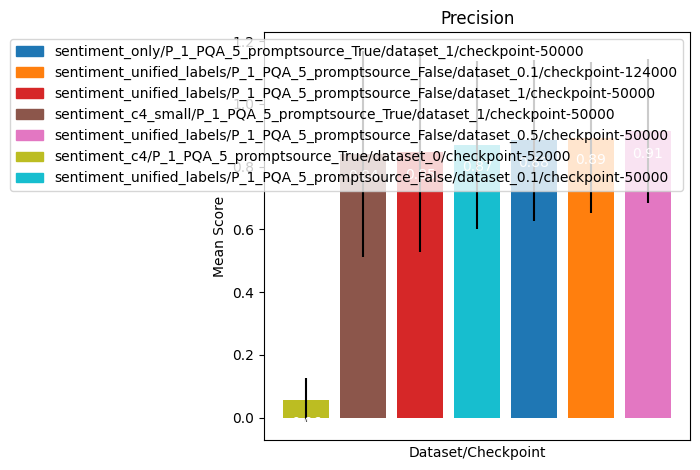

In [16]:
def compute_metrics(df, metric='precisions'):
    keys = df['level_0'].unique()

    metrics = {}
    for key in keys:
        subset = df[df['level_0'] == key]
        metric_values = subset[metric]

        metrics[key] = {
            'mean': np.mean(metric_values),
            'std': np.std(metric_values),
            'samples': metric_values.tolist()  # Saving samples can be useful for future analysis or plots
        }

    return metrics

metrics_dict = compute_metrics(df, metric='precisions')

score_title = 'Precision'
plt.title('Precisions')
plot_rank_classification(metrics_dict, score_title, fig_save_path)

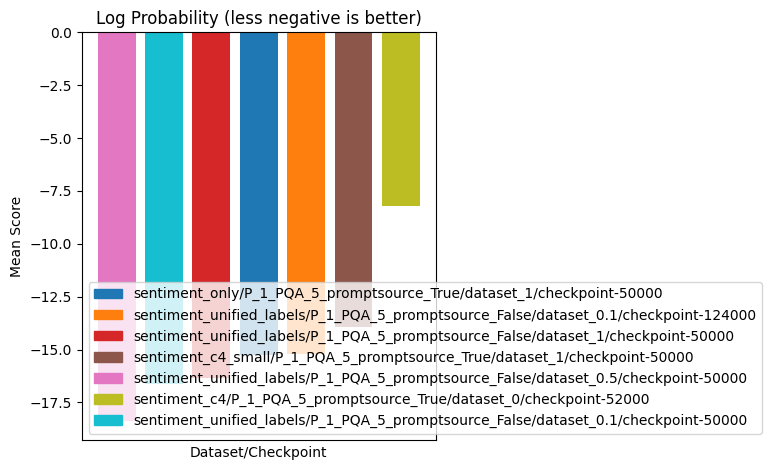

In [17]:
# log_probs_mean_1 = logprob_dict['dataset_1/checkpoint-84500']['mean']
# log_probs_mean_0 = logprob_dict['dataset_0/checkpoint-145500']['mean']

# log_probs_std_1 = logprob_dict['dataset_1/checkpoint-84500']['std']
# log_probs_std_0 = logprob_dict['dataset_0/checkpoint-145500']['std']

# plt.title('Log Probability (less negative is better)')
# plt.bar(['dataset_mixing', 'dataset_nomixing'], [log_probs_mean_1, log_probs_mean_0], yerr=[log_probs_std_1, log_probs_std_0])
# plt.savefig(os.path.join(fig_save_path, 'log_probs.png'))

plot_rank_classification(logprob_dict, 'Log Probability (less negative is better)', fig_save_path, std_error=False)